A simple local circuit with interacting populations of excitatory and inhibitory neurons. Propagation between nodes takes place both along the surface and along white-matter tracts. Adding in delays along surface and white matter tracts - Sean Froudist-Walsh & Daniel Margulies. April 2019

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas
import scipy.io as sio
import brian2
import os
import copy

/Users/seanfw/miniconda2/lib/python2.7/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


Define the function that transforms input current to changes in firing rate for excitatory neurons (Abbott and Chance, 2005). 
<br>
$$r_E = \frac{aI_{syn,E} - b}{1 - e^{-d(aI_{syn,E} - b)}} $$

Update the firing rates of the interneurons using a threshold linear input/output function
$$ \begin{cases}
  r_I = \frac{1}{g_2}(c_II_{syn,I} - c_0) + r_0 & \text{for } r_I\ge 0\\    
  r_I = 0     & \text{otherwise }  
\end{cases} $$



In [2]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        return current_to_frequency_E(input_current,parameters['a_E'],parameters['b_E'],parameters['d_E'])
    if population_type == 'I':
        return current_to_frequency_I(input_current,parameters['c_I'],parameters['r0_I'])

def current_to_frequency_E(input_current1,a,b,d):
    return np.divide((a*input_current1 - b),(1 - np.exp(-d*(a*input_current1 - b))))

def current_to_frequency_I(input_current1,c_I,r_0):
    return np.maximum(c_I*input_current1 + r_0,0) 

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + (1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [3]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_NMDA'] + parameters['gam']*(1 - S_NMDA_prev)*rate_now

Define the GABA derivative
<br>
$$ \frac{dS_{GABA}}{dt} = -\frac{S_{GABA}}{\tau_{GABA}} + \gamma_Ir_I$$
(Wong & Wang, 2006)

In [4]:
def GABA_deriv(S_GABA_prev,rate_now,parameters):

    return -S_GABA_prev/parameters['tau_GABA'] + rate_now 

### Model:

In [5]:
#g_E_self, g_IE, g_I_self, g_EI
g_E_self=0.39
g_IE=0.23
g_I_self=-0.05
g_EI=-0.4

parameters = {}

parameters.update({ # Time constants
                    'tau_NMDA': 0.06   * brian2.second,    # s 
                    'tau_AMPA': 0.002   * brian2.second,    # s 
                    'tau_GABA': 0.005  * brian2.second,    # s 
                    'tau_rates': 0.002 * brian2.second,    # s 

                    # f-I curve parameters - E populations
                    'a_E': 270.  * brian2.Hz/brian2.nA / 2.,  # Hz/nA
                    'b_E': 108.  * brian2.Hz / 2.,            # Hz
                    'd_E': 0.154 * brian2.second * 2.,        # s
                    'gam': 0.641 * 2.,                         # unitless

                    # f-I curve parameters - I populations
                    'c_I': 330 * brian2.Hz/brian2.nA,                 # Hz/nA
                    'r0_I': -95 * brian2.Hz,

                    # Strength of connections from E cells
                    'g_E_self': g_E_self * brian2.nA ,        # nA - from E to E
                    'g_IE': g_IE * brian2.nA ,            # nA - from E to I

                    # Strength of connections from I cells
                    'g_I_self': g_I_self  * brian2.nA,     # nA  - from I to I
                    'g_EI': g_EI * brian2.nA,     # nA  - from I to E

                    # Strength of mid-range connections (along surface)
                    'g_E_midRange': 0.09 * brian2.nA,
                    'g_E_longRange': 0.2 * brian2.nA,
    
    
                    # Background inputs
                    'I0_E': 0.20     * brian2.nA,           # nA - background onto E population
                    'I0_I': 0.18      * brian2.nA,         # nA - background onto I population

                    # Noise std dev
                    'std_noise': 0.01 * brian2.nA,         # nA  - standard deviation of noise input  

                    # initial values
                    'r0_E': 5 * brian2.Hz,

                    # stimulus strength
                    'stim_strength': 0.2 * brian2.nA
    
                
                        })      

######## LOCAL CONNECTIVITY MATRIX ########
J =  np.array([
                [parameters['g_E_self'] , parameters['g_EI']],
                [parameters['g_IE'] , parameters['g_I_self']]

              ]) * brian2.amp

pops = ['E','I']
pops_column_list  = ['from '+ mystring for mystring in pops]
pops_row_list  = ['to '+ mystring for mystring in pops]

J_NMDA = J*((J>0).astype(np.int))
J_GABA = J*((J<0).astype(np.int))

df_J = pandas.DataFrame(J, columns=pops_column_list, index=pops_row_list)

num_pops  = J.shape[0]
num_vertices = 25

# Choose initial values for rates and synapse variables
R0 = np.ones((num_vertices, num_pops))
R0 = R0 * parameters['r0_E']
S_NMDA0 = np.ones((num_vertices,num_pops)) * 0.1
S_GABA0 = np.zeros((num_vertices,num_pops))

#### Set up simulation details
# Set up simulation parameters
dt=0.5 * brian2.ms  # timestep 
trial_length=5000 * brian2.ms # trial length (s)
num_iterations = int(trial_length/dt)
time = np.arange(0, trial_length, dt)


# Preassign rate and synapse matrices
R           = np.zeros((num_iterations,num_vertices,num_pops)) * brian2.Hz
R[0,:,:]      = R0
S_NMDA      = np.zeros((num_iterations,num_vertices,num_pops))
S_NMDA[0,:,:] = S_NMDA0
S_GABA      = np.zeros((num_iterations,num_vertices,num_pops))
S_GABA[0,:,:] = S_GABA0

# # Preassign external inputs
I_ext        = np.zeros((num_iterations,num_vertices,num_pops)) * brian2.amp
stim_on      = 1 * brian2.second #s
stim_off     = 1.5 * brian2.second #s

# Let's apply external stimulation to V1 populations E1 & E2
V1_index = 0
I_ext[int(stim_on/dt):int(stim_off/dt),V1_index,0] = parameters['stim_strength']

# Create matrices in which we can store the currents
I_longRange_NMDA = np.zeros((num_iterations,num_vertices,num_pops)) * brian2.pA
I_midRange_NMDA = np.zeros((num_iterations,num_vertices,num_pops)) * brian2.pA
I_local_NMDA =  np.zeros((num_iterations,num_vertices,num_pops)) * brian2.pA
I_local_GABA =  np.zeros((num_iterations,num_vertices,num_pops)) * brian2.pA
I_total      =  np.zeros((num_iterations,num_vertices,num_pops)) * brian2.pA
I_noise      =  np.zeros((num_vertices,num_pops)) * brian2.pA

# # Define background inputs
I_0 = np.zeros((num_vertices, num_pops)) * brian2.pA
I_0[:,pops.index('E')] = parameters['I0_E']
I_0[:,pops.index('I')] = parameters['I0_I']

# Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.
# https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process

# Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_vertices,num_pops))

# prepare the right hand side of the above equation
noise_rhs = eta*((np.sqrt(parameters['tau_AMPA']*np.power(parameters['std_noise'],2))*np.sqrt(dt))/parameters['tau_AMPA'])

#print(I_0)

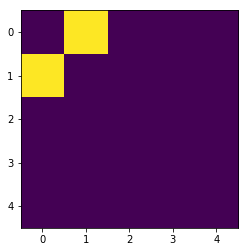

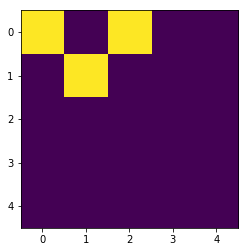

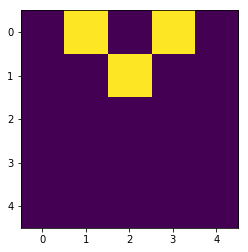

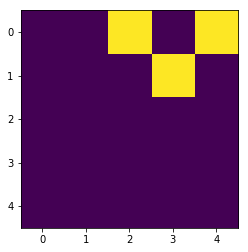

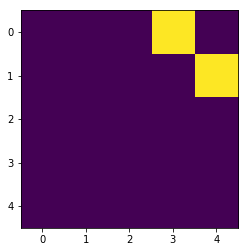

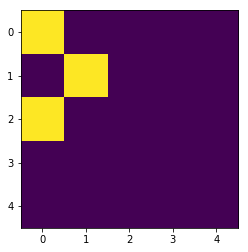

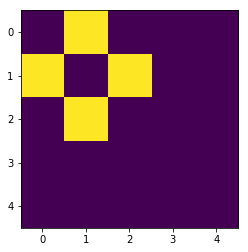

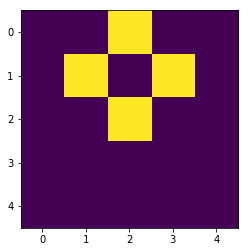

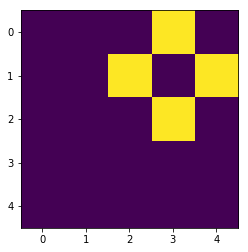

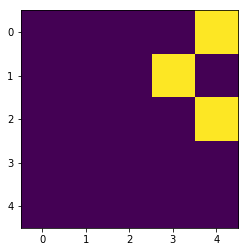

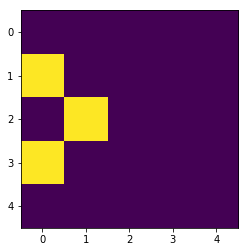

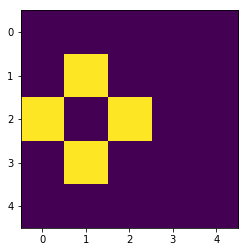

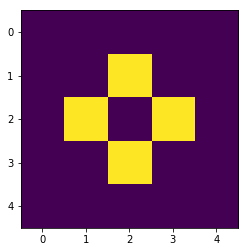

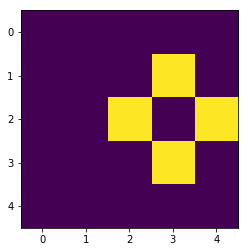

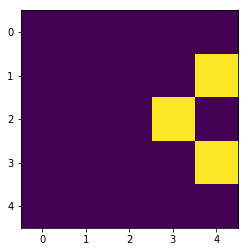

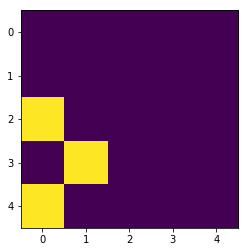

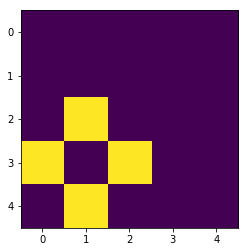

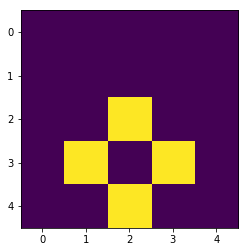

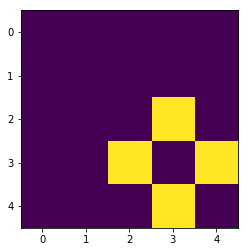

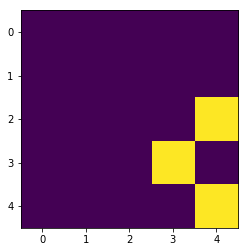

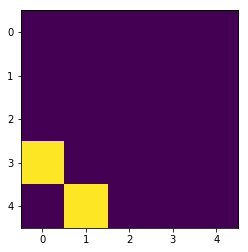

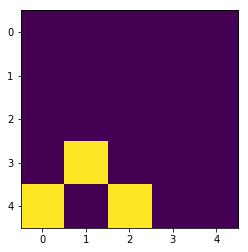

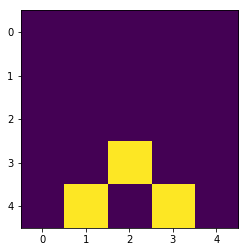

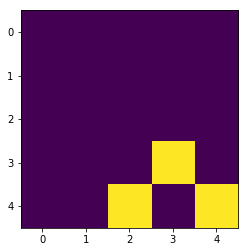

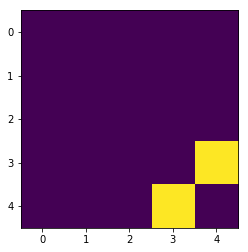

In [6]:
# Surface connectivity
import numpy as np
edges = {}
num_nodes = 25
for i in range(num_nodes):
    e = []
    if i >= np.sqrt(num_nodes):
        e.append(i-np.sqrt(num_nodes))
    if i < num_nodes-np.sqrt(num_nodes):
        e.append(i+np.sqrt(num_nodes))
    if i % np.sqrt(num_nodes) != 0:
        e.append(i-1)
    if i % np.sqrt(num_nodes) != np.sqrt(num_nodes)-1:
        e.append(i+1)
    edges.update({
        str(i): [int(j) for j in e]
    })
surface_connectivity = np.zeros((num_nodes,num_nodes))
for i in range(num_nodes):
    surface_connectivity[i,edges[str(i)]] = 1

# check connectivity:
import matplotlib.pylab as plt
for i in range(num_nodes):
    plt.imshow(np.reshape(surface_connectivity[:,i],(5,5)))
    plt.show()


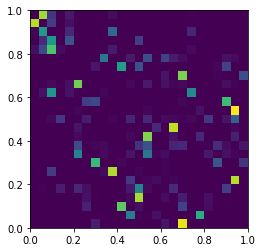

In [7]:
# White matter tract connectivity
tract_connectivity = np.zeros((num_nodes,num_nodes))
# Load in Henry Kennedy's tract-tracing data as an example of realistic connectivity 
# (although bear in mind that it's at the level of areas, not vertices)

subgraph_data = sio.loadmat('ordered_SLN_FLN_29_subgraph.mat')
fln = subgraph_data['OrderedFLNmat']
fln_25 = fln[:25,:25]

# Normalise inputs to sum to 1
fln_rowtotal = np.sum(fln_25,axis=1)
fln_rowtotal_mat = np.matlib.repmat(fln_rowtotal, num_nodes,1).T
tract_connectivity = fln_25/fln_rowtotal_mat

plt.imshow(tract_connectivity, extent=[0, 1, 0, 1])

In [13]:
# Let's calculate the delays

# Along the surface, all nodes area neighbours. They are ~1mm apart. 
# Activity propagates along the surface at about 0.33 m/s = 330mm/s = 0.33mm/ms = 0.165 mm/dt
# Therefore there is a delay of about 6 timesteps for activity propagation along the surface
# (Girard, Hupé & Bullier, J Neurophysiol, 2001)

# Along the white matter, there are connections of different lengths.
distances = np.zeros((num_nodes,num_nodes))

# Create the row-column indices (i.e. locations in space)
indices = range(int(np.sqrt(num_nodes)))
rows_mat = np.matlib.repmat(indices, int(np.sqrt(num_nodes)),1).T
cols_mat = np.matlib.repmat(indices, int(np.sqrt(num_nodes)),1)
rows_vec = np.reshape(rows_mat,num_nodes)
rows_vec.shape = (num_nodes,1)
cols_vec = np.reshape(cols_mat,num_nodes)
cols_vec.shape = (num_nodes,1)
indices  = np.concatenate((rows_vec, cols_vec),axis=1)

from scipy.spatial import distance_matrix
distances = distance_matrix(indices, indices) # this is distance in vertices - let's assume = 1mm


tract_delays = numpy.round(distances/1.75, decimals=0).astype(int) # in units of timesteps
# In the white matter, activity propagates at about 3.5m/s, but it might propagate more quickly for 
# longer/larger tracts. 
# 3.5 m/s = 3.5mm/ms = 1.75mm/dt
# (Girard, Hupé & Bullier, J Neurophysiol, 2001)

max_delay = np.max(tract_delays) # in timesteps

# initialise the matrix which stores the delayed 
# synaptic drive variables (transmitted via white matter tracts)
S_tract_delay = np.zeros((num_vertices,num_vertices)) 

print(max_delay)

3


In [15]:
#### Run model:
for i_t in range(max_delay+1,num_iterations):

    # update noise - dims = num local pops x num areas
    I_noise = I_noise + -I_noise*(dt/parameters['tau_AMPA']) + noise_rhs[i_t-1,:,:]

    # long range NMDA (along white matter tracts)
    I_longRange_NMDA[i_t-1,:,0] = parameters['g_E_longRange'] * np.sum(tract_connectivity*S_tract_delay,axis=1)
    
    # mid range NMDA (along surface), with a 6 timestep delay
    I_midRange_NMDA[i_t-1,:,:] = parameters['g_E_midRange'] * surface_connectivity.dot(S_NMDA[i_t-7,:,:])
    
    # local NMDA
    I_local_NMDA[i_t-1,:,:] = J_NMDA.dot(S_NMDA[i_t-1,:,:].T).T
    
    # sum up all the local GABA current onto E and I cell somas
    I_local_GABA[i_t-1,:,:] = J_GABA.dot(S_GABA[i_t-1,:,:].T).T

    # Define total input current as sum of local NMDA & GABA inputs, with background, external currents & noise & longRange
    I_total[i_t-1,:,:] = I_local_NMDA[i_t-1,:,:] +  I_local_GABA[i_t-1,:,:] + I_0 + I_ext[i_t-1,:,:] + I_noise + I_midRange_NMDA[i_t-1,:,:] + I_longRange_NMDA[i_t-1,:,:]

    # Update the firing rates of the excitatory population
    R[i_t,:,0] = R[i_t-1,:,0] + dt*current_to_frequency(I_total[i_t-1,:,0],'E',parameters)/parameters['tau_rates']-dt*R[i_t-1,:,0]/parameters['tau_rates']

    # Update the firing rates of the inhibitory population. 
    R[i_t,:,1] = R[i_t-1,:,1] + dt*current_to_frequency(I_total[i_t-1,:,1],'I',parameters)/parameters['tau_rates']-dt*R[i_t-1,:,1]/parameters['tau_rates']

    # Update the NMDA synapses
    S_NMDA[i_t,:,0] = S_NMDA[i_t-1,:,0] + dt*NMDA_deriv(S_NMDA[i_t-1,:,0],R[i_t,:,0],parameters)

    S_tract_delay = S_NMDA[i_t-tract_delays,range(num_vertices),0]

    
    # Update the GABA synapses
    S_GABA[i_t,:,1] = S_GABA[i_t-1,:,1] + dt*GABA_deriv(S_GABA[i_t-1,:,1],R[i_t,:,1],parameters)


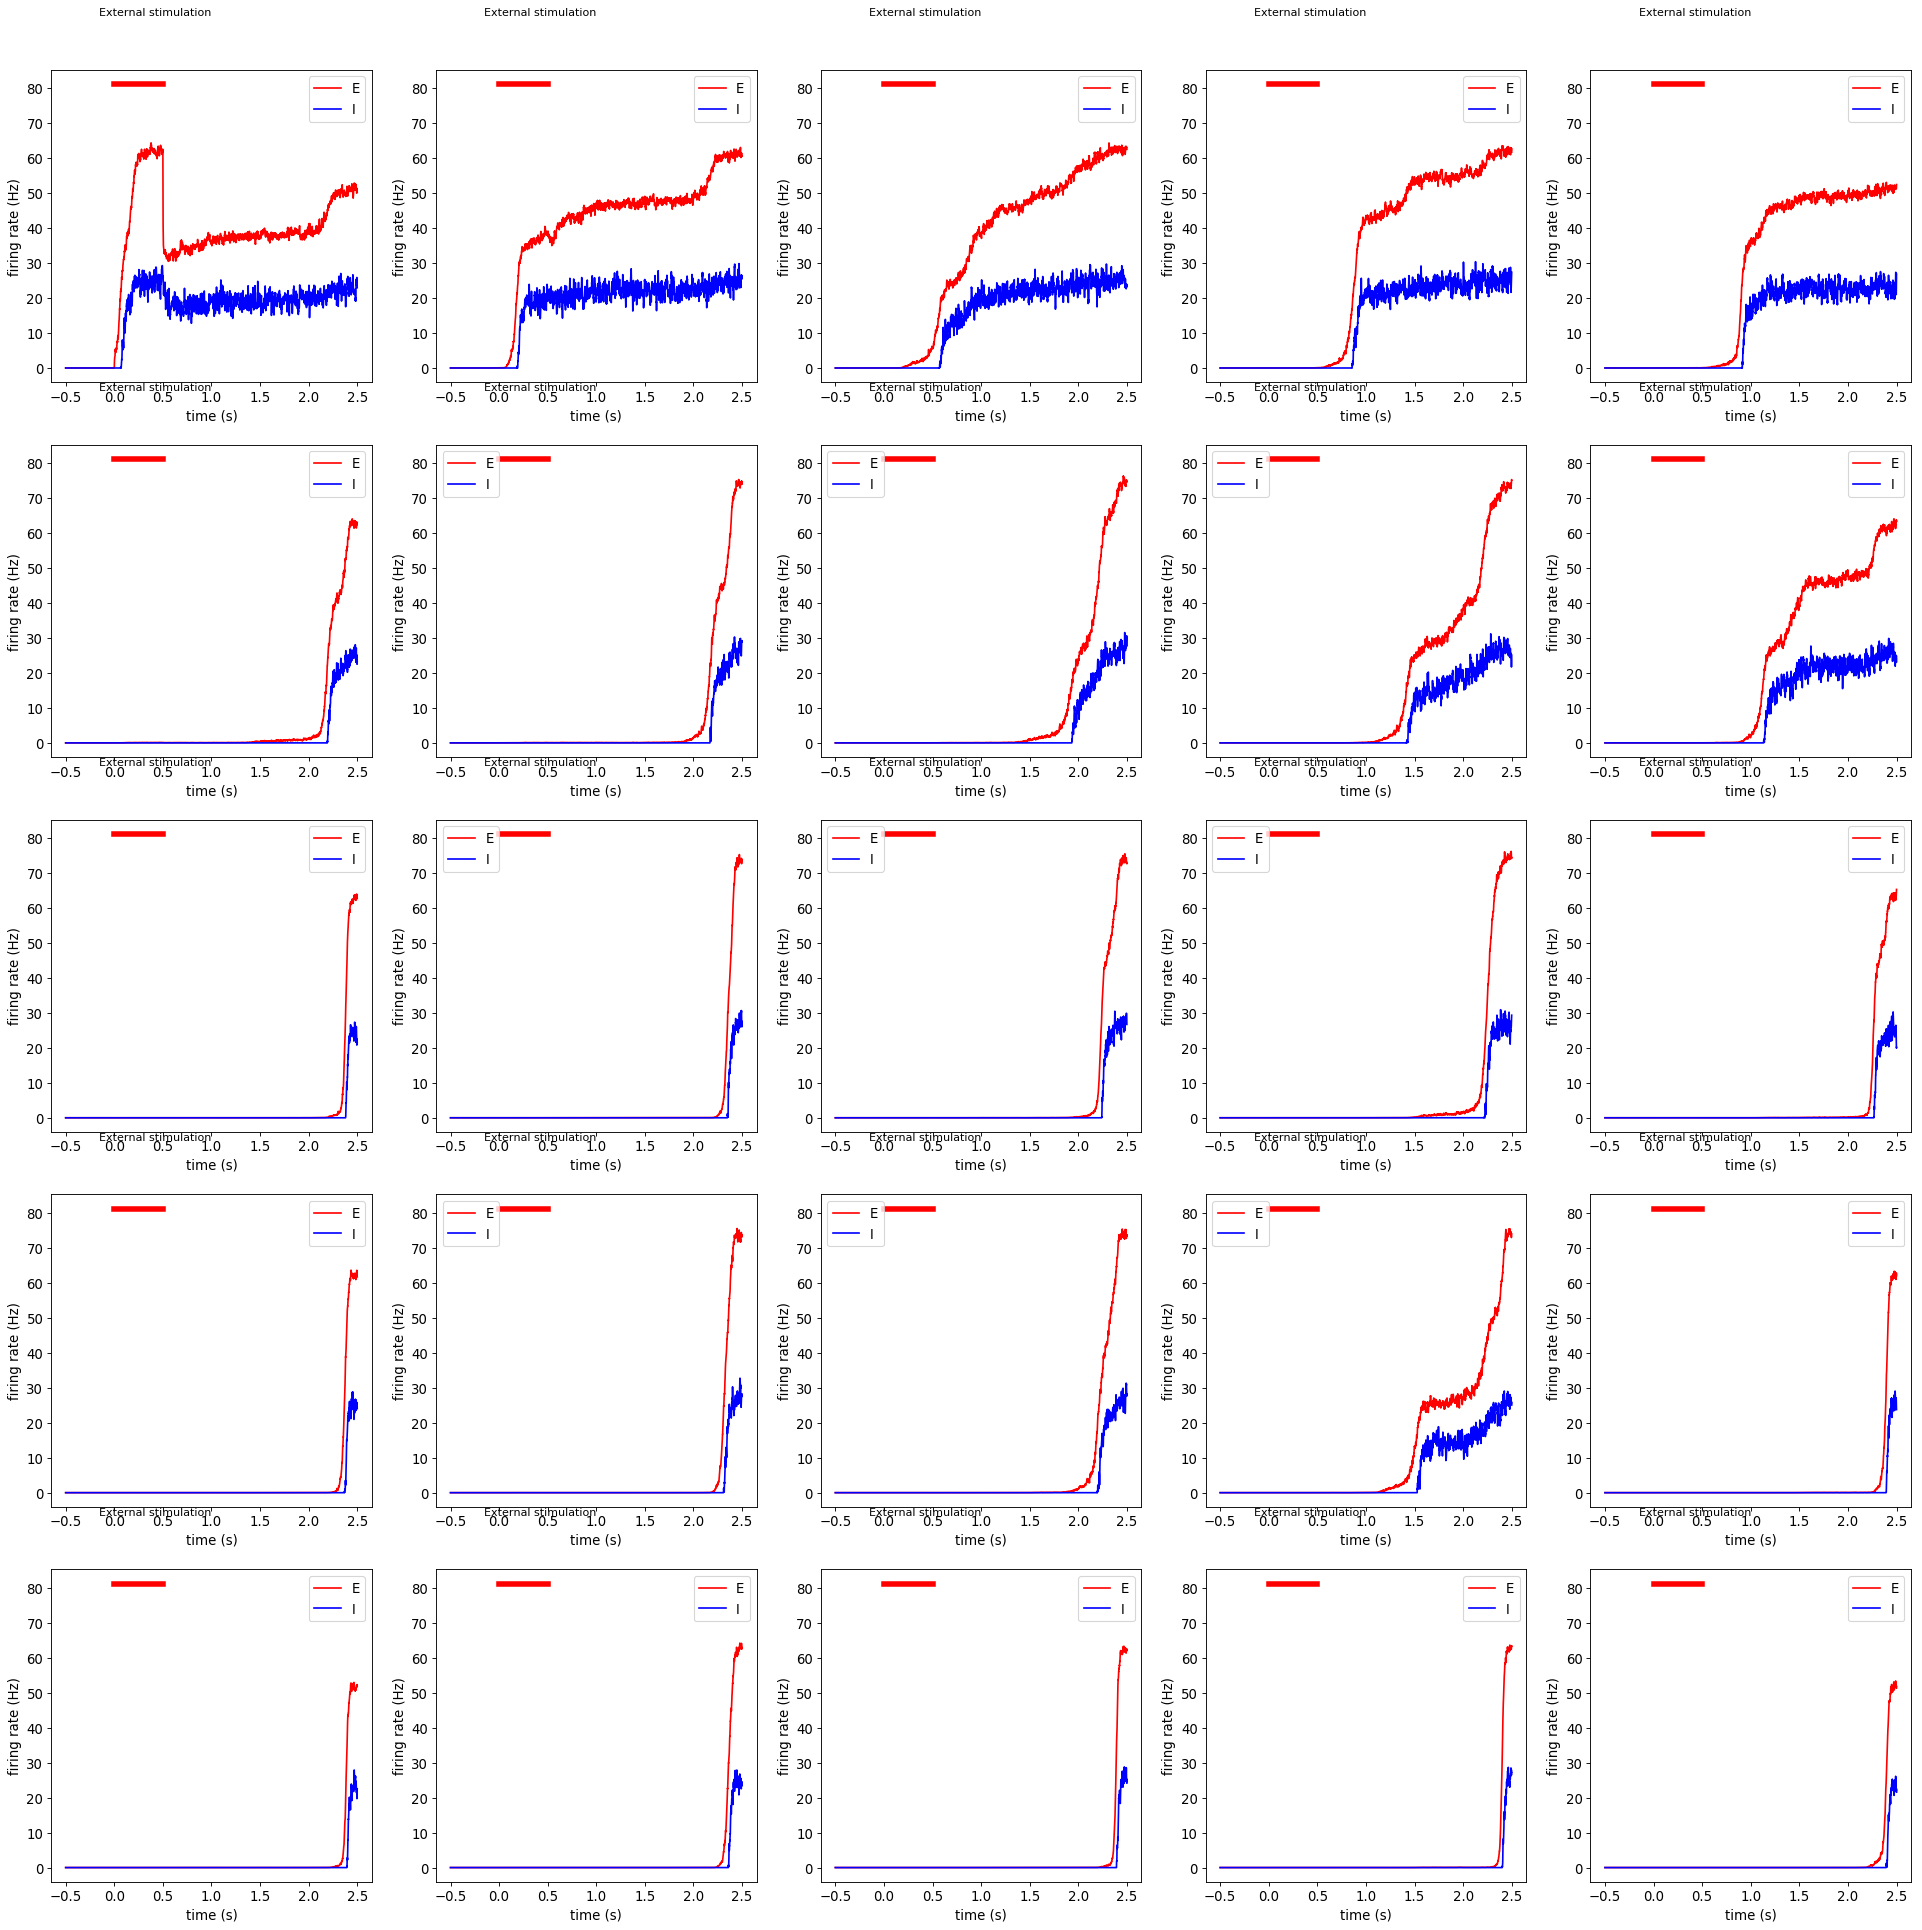

In [16]:
fig=plt.figure(figsize=(30,30), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
start_time = 0.5 #seconds
end_time = 3.5 #seconds

for i in range(1,num_vertices+1):
    ax = plt.subplot(np.sqrt(num_vertices), np.sqrt(num_vertices), i)    

    # Plot E population rates
    plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,0],color='r')
    # Plot I population rates
    plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,1],color='b')

    # Plot the stimulation time
    plt.plot([stim_on-1*brian2.second,stim_off-1*brian2.second],[np.max(R+0.05*np.max(R)),np.max(R+0.05*np.max(R))],color='r',linewidth=5.0)

    # place text above the stimulation line
    axes = plt.gca()
    axes.text(0.15, 1.2,'External stimulation', transform=axes.transAxes, fontsize=10, verticalalignment='top')

    plt.legend(['E','I'])
    plt.xlabel('time (s)')
    plt.ylabel('firing rate (Hz)')
    # plt.ylim(0, 80) 

plt.show()

In [ ]:
# Notes (4.4.19):
# 1. increase inhibition firing rate compared to excitatory populations
# 2. AMPA receptors? 
# 3. Delays?
# 4. Mechanism such that firing dies off? Oscillating?
# 5. Bring in heterogeneity
# 6. real structural basis for connectivity data

In [12]:
S_tract_delay = S_NMDA[i_t-tract_delays,range(num_vertices),0]
print(np.sum(tract_connectivity*S_tract_delay,axis=1))
print(S_tract_delay.shape)

[0.09047934 0.09580111 0.0906583  0.09913136 0.07375567 0.03207223
 0.07998865 0.07250851 0.01819991 0.09534837 0.03774159 0.00498535
 0.08528921 0.09455652 0.09152536 0.06863236 0.09535584 0.09996502
 0.08322136 0.08373158 0.03467574 0.0945825  0.024438   0.06133973
 0.08704402]
(25, 25)


In [17]:
print(parameters['g_E_longRange'] * np.sum(tract_connectivity*S_tract_delay,axis=1))

[164.58234909 160.22621114 164.89321683 164.81539182 165.30741129
 168.87143208 167.06204543 167.76559274 166.11932436 167.12692131
 167.44179759 165.86345488 166.09036285 169.44868506 169.0505071
 167.94704575 167.23622619 167.78954429 165.88118976 166.52871246
 168.49797704 169.50347823 166.86535132 167.16944567 169.99368927] pA
